In [3]:
import ast
import re
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_mi_acc(logs_list, labels, title):
    """
    Pour chaque log (chaîne de caractères), extrait les blocs (mi_acc, doa),
    calcule la moyenne et l'écart‐type de mi_acc sur les folds, et trace une
    courbe ±1 std pour chacun.

    Cette version gère les deux formats de logs :
    - float simples parsables par ast.literal_eval
    - valeurs np.float64(...)

    Paramètres
    ----------
    logs_list : list of str
        Liste des textes de logs complets. Chaque élément contient plusieurs
        blocs "(dict_mi_acc, dict_doa)" pour les folds.
    labels : list of str
        Étiquettes à utiliser pour chaque courbe (même taille que logs_list).
    title : str
        Titre de la figure.

    Retour
    ------
    fig, ax : matplotlib Figure et Axes
    """
    def extract_mi_dicts(log_str):
        """Retourne la liste des dicts {'key': {'mi_acc': val}} extraits du log."""
        mi_dicts = []
        i, n = 0, len(log_str)
        while i < n:
            if log_str[i] == '(':
                j = i + 1
                # sauter les espaces
                while j < n and log_str[j].isspace():
                    j += 1
                # on veut un tuple qui commence par un dict
                if j < n and log_str[j] == '{':
                    depth, k = 1, j
                    # trouver la parenthèse fermante correspondante
                    while k < n-1 and depth > 0:
                        k += 1
                        if log_str[k] == '(':
                            depth += 1
                        elif log_str[k] == ')':
                            depth -= 1
                    if depth == 0:
                        snippet = log_str[i:k+1]
                        # nettoyer les np.float64(...) en simples floats
                        snippet_clean = re.sub(
                            r'np\.float64\(\s*([^\)]+?)\s*\)',
                            r'\1',
                            snippet
                        )
                        try:
                            tup = ast.literal_eval(snippet_clean)
                            # si c'est bien un tuple (dict, dict)
                            if (isinstance(tup, tuple) and len(tup) == 2
                                    and isinstance(tup[0], dict)):
                                mi_dicts.append(tup[0])
                                i = k
                        except (ValueError, SyntaxError):
                            # on ignore et on continue la recherche
                            pass
            i += 1
        if not mi_dicts:
            raise ValueError("Aucun bloc (mi_acc, doa) trouvé dans un des logs.")
        return mi_dicts

    if len(logs_list) != len(labels):
        raise ValueError("La longueur de logs_list et de labels doit être la même.")

    fig, ax = plt.subplots(figsize=(8, 5))

    for log_str, label in zip(logs_list, labels):
        # extraction des dicts mi_acc
        mi_dicts = extract_mi_dicts(log_str)
        # intersection des clés communes à tous les folds
        key_sets = [set(d.keys()) for d in mi_dicts]
        keys = sorted(set.intersection(*key_sets))
        # construction du tableau (folds × clés)
        data = np.array([[d[k]['mi_acc'] for k in keys] for d in mi_dicts], dtype=float)
        mean = data.mean(axis=0)
        std  = data.std(axis=0)

        # tracé de la courbe ± 1 écart-type
        ax.plot(keys, mean, marker='o', label=label)
        ax.fill_between(keys, mean - std, mean + std, alpha=0.3)

    ax.set_xlabel('Clé')
    ax.set_ylabel('mi_acc')
    ax.set_title(title)
    ax.set_xticks(keys)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

    return fig, ax


In [4]:
with open('../data/T8Prior.txt', 'r') as f:
    T8Prior = f.read()
with open('../data/T5Prior.txt', 'r') as f:
    T5Prior = f.read()
with open('../data/T3Prior.txt', 'r') as f:
    T3Prior = f.read()
with open('../data/T10Prior.txt', 'r') as f:
    T10Prior = f.read()
with open('../data/T8L0.txt', 'r') as f:
    T8L0 = f.read()
with open('../data/T8Priorv2.txt', 'r') as f:
    T8Priorv2 = f.read()
with open('../data/T8NoPriorv2.txt', 'r') as f:
    T8NoPriorv2 = f.read()
with open('../data/T8PriorRetrainv2.txt', 'r') as f:
    T8PriorRetrainv2 = f.read()

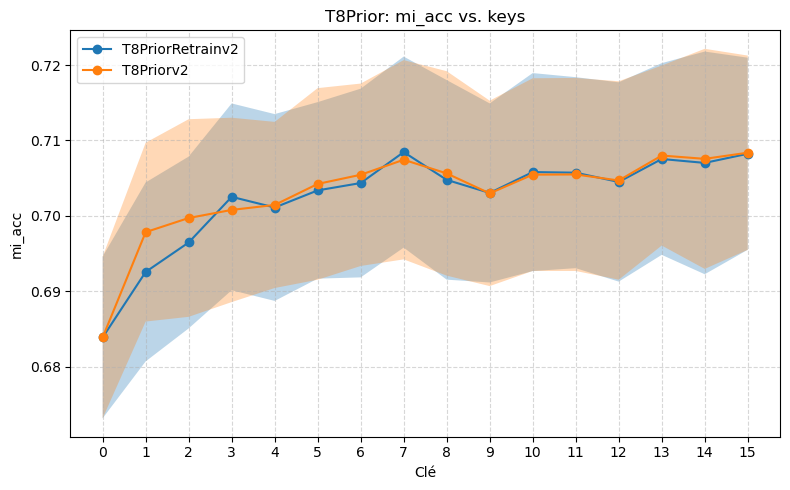

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'T8Prior: mi_acc vs. keys'}, xlabel='Clé', ylabel='mi_acc'>)

In [5]:
plot_multiple_mi_acc([T8PriorRetrainv2,T8Priorv2], ['T8PriorRetrainv2','T8Priorv2'], 'T8Prior: mi_acc vs. keys')

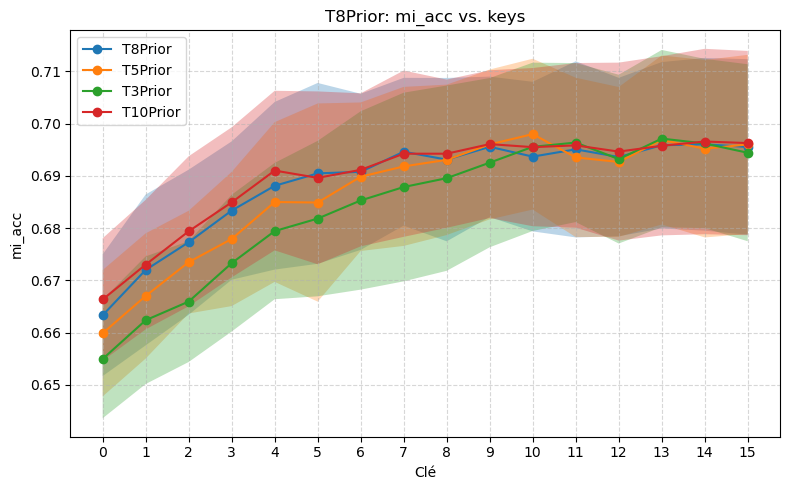

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'T8Prior: mi_acc vs. keys'}, xlabel='Clé', ylabel='mi_acc'>)

In [22]:
plot_multiple_mi_acc([T8Prior,T5Prior,T3Prior,T10Prior], ['T8Prior','T5Prior','T3Prior','T10Prior'], 'T8Prior: mi_acc vs. keys')

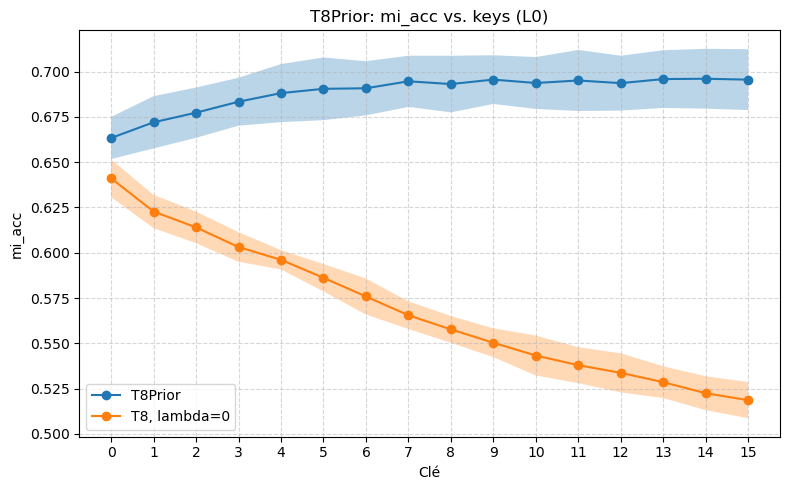

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'T8Prior: mi_acc vs. keys (L0)'}, xlabel='Clé', ylabel='mi_acc'>)

In [6]:
plot_multiple_mi_acc([T8Prior,T8L0], ['T8Prior','T8, lambda=0'], 'T8Prior: mi_acc vs. keys (L0)')